# <font color='crimson'>Data Set Information:</font>

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

# Attribute Information:

Input variables:
## bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
## related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
## other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
## social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

# <font color='crimaon'>Import Required Library</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import classification_report,precision_score,recall_score,accuracy_score,f1_score,roc_auc_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format='{:,.2f}'.format

# <font color = 'crimson'>Extracting data</font>

In [2]:
bank = pd.read_csv('bank-full.csv', sep=';')
print('Shape of our data {}'.format(bank.shape))

Shape of our data (45211, 17)


# <font color = 'crimson'>Data Info</font>

In [3]:
#checking info
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


**Observations**

+ Total observations 45211 which contains 17 fields.
+ Data type contains 7 int field and 10 objects fields.
+ Zero null values.


# <font color = 'crimson'>Data Head</font>

In [4]:
# checking data 
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


**Data does'nt contain null values but it does contain unknown values.**

In [5]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [6]:
bank.columns  =['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit']

# <font color = 'crimson'>Target Variable</font>

In [7]:
#dependent value insight
bank.deposit.value_counts().to_frame()

,deposit
no,39922
yes,5289


# <font color = 'crimson'>Separating numerical and categorical fields</font>

In [8]:
numerical_dtypes = ['int64']
numerical_data = bank.select_dtypes(include=numerical_dtypes).columns

In [9]:
categorical_dtypes = ['object']
categorical_data = bank.select_dtypes(include=categorical_dtypes).columns

# <font color = 'crimson'>Categorical Variable Reading</font>

In [10]:
for i in list(bank.columns[bank.dtypes=='object']):
    print(bank[i].value_counts())
    print()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

no     44396
yes      815
Name: default, dtype: int64

yes    25130
no     20081
Name: housing, dtype: int64

no     37967
yes     7244
Name: loan, dtype: int64

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype:

**Observation**
+ No na values but there are some unknown values in few categorical fields, which needs to be treated.

### Nominal Data

+ marital
+ contact
+ deposit
+ cellular
+ loan
+ deposit
+ housing
+ default
+ job

### Ordinal Data

+ education
+ poutcome
+ month

In [11]:
nominal_category = ['marital','contact','deposit','cellular','loan','deposit','housing','default','job']
ordinal_category = ['education','potcome','month']

# <font color = 'crimson'>Null Value Detection</font>

In [12]:
bank.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

# <font color = 'crimson'>Unknown observation treatment</font>

In [13]:
#to many unknown values, droping the column
del(bank['poutcome'])

In [14]:
# unknown treatment in education
bank.education.value_counts(dropna=False)

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [15]:
bank['education']=bank['education'].replace('unknown','primary')

In [16]:
bank['education'].value_counts()

secondary    23202
tertiary     13301
primary       8708
Name: education, dtype: int64

In [17]:
#unknown treatment in job
bank.groupby(['marital'])['job'].value_counts()

marital   job          
divorced  management       1111
          technician        925
          admin.            750
          blue-collar       750
          services          549
          retired           425
          housemaid         184
          entrepreneur      179
          unemployed        171
          self-employed     140
          unknown            17
          student             6
married   blue-collar      6968
          management       5400
          technician       4052
          admin.           2693
          services         2407
          retired          1731
          entrepreneur     1070
          self-employed     993
          housemaid         912
          unemployed        731
          unknown           203
          student            54
single    management       2947
          technician       2620
          blue-collar      2014
          admin.           1728
          services         1198
          student           878
          self-e

In [18]:
bank.groupby(['housing'])['job'].value_counts()

housing  job          
no       management       4780
         technician       3482
         blue-collar      2684
         admin.           1989
         retired          1773
         services         1388
         housemaid         842
         self-employed     814
         unemployed        760
         student           689
         entrepreneur      618
         unknown           262
yes      blue-collar      7048
         management       4678
         technician       4115
         admin.           3182
         services         2766
         entrepreneur      869
         self-employed     765
         unemployed        543
         retired           491
         housemaid         398
         student           249
         unknown            26
Name: job, dtype: int64

In [19]:
bank['job']=bank['job'].replace('unknown','student')

In [20]:
bank['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student          1226
Name: job, dtype: int64

# <font color = 'green'>Bivariate Analysis of Categorical Variables</font>

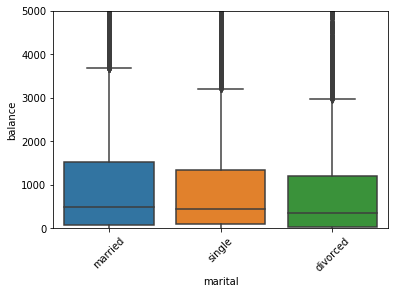

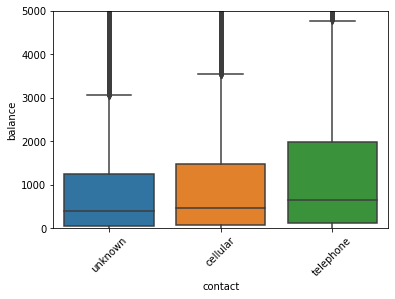

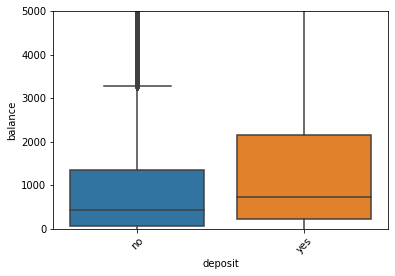

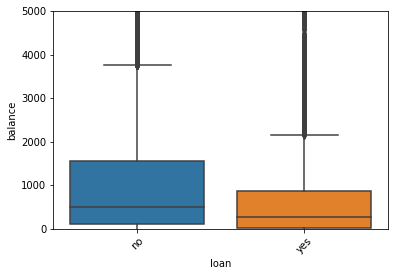

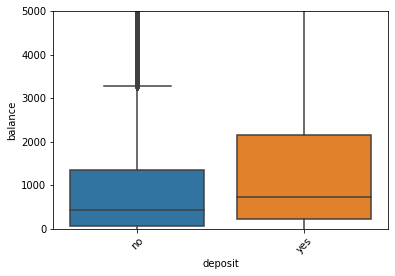

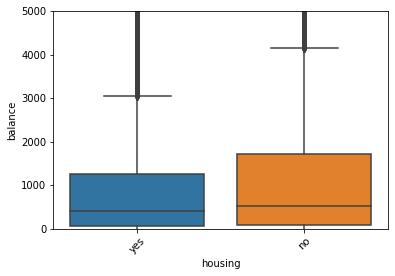

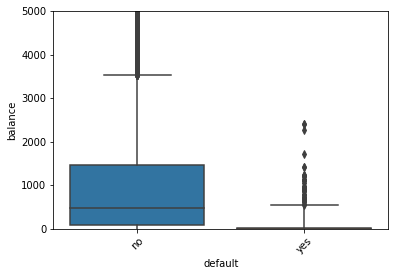

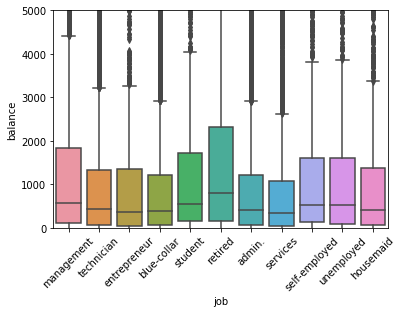

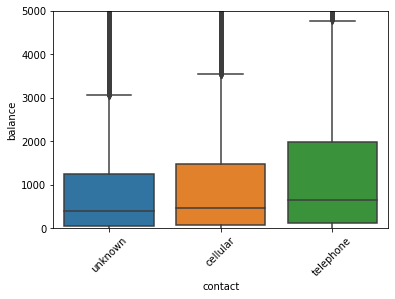

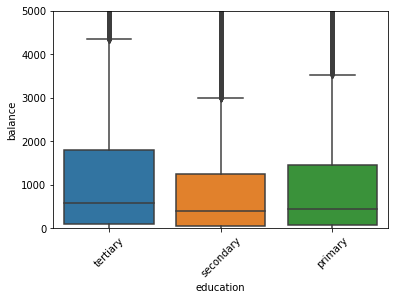

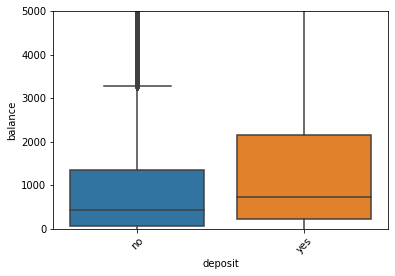

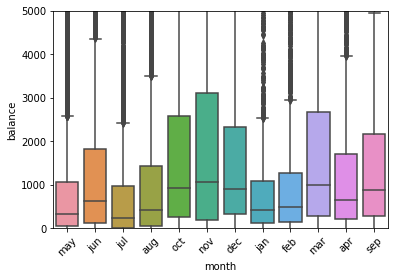

In [21]:
# Check distribution of categorical variables.
for i in ['marital','contact','deposit','loan','deposit','housing','default','job','contact',
          'education','deposit','month']:
    sns.boxplot(x=i,y='balance',data=bank)
    plt.xticks(rotation=45)
    plt.ylim(0,5000)
    plt.show()


**Observation**
+ Month and job requied encoding.
+ Default is not contributing much.

In [22]:
categorical_data

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'deposit'],
      dtype='object')

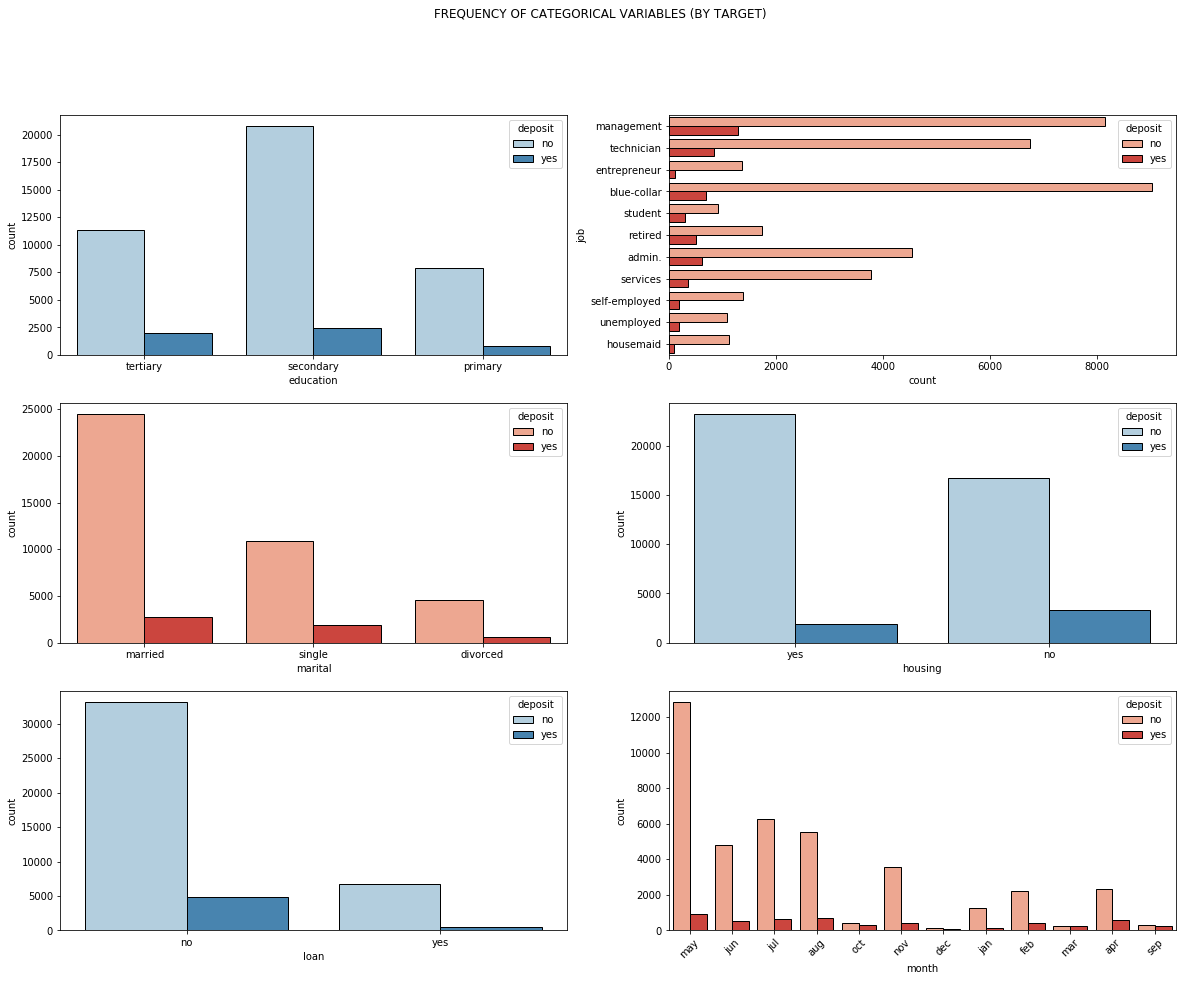

In [23]:
#Creating subset for categorical field visualization

f, plot = plt.subplots(3, 2, figsize=(20, 15), facecolor='white')

f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)')

plot1 = sns.countplot(x = "education",data=bank,hue="deposit",palette="Blues",ax=plot[0,0],edgecolor = 'black')
plot2 = sns.countplot(y = "job",data=bank,hue="deposit",palette="Reds",ax=plot[0,1],edgecolor = 'black')
plot3 = sns.countplot(x = "marital",data=bank,hue="deposit",palette="Reds",ax=plot[1,0],edgecolor = 'black')
plot4 = sns.countplot(x = "housing",data=bank,hue="deposit",palette="Blues",ax=plot[1,1],edgecolor = 'black')
plot5 = sns.countplot(x = "loan",data=bank,hue="deposit",palette="Blues",ax=plot[2,0],edgecolor = 'black')
plot6 = sns.countplot(x = "month",data=bank,hue="deposit",palette="Reds",ax=plot[2,1],edgecolor = 'black')
plt.xticks(rotation=45)
plt.show()

**observation**
+ Our dependent variable is imbalaned there is a huge variablity between the classes, one is going very high another have low number of data points.

# <font color = 'green'>Univariate Analysis of Categorical Variables</font>

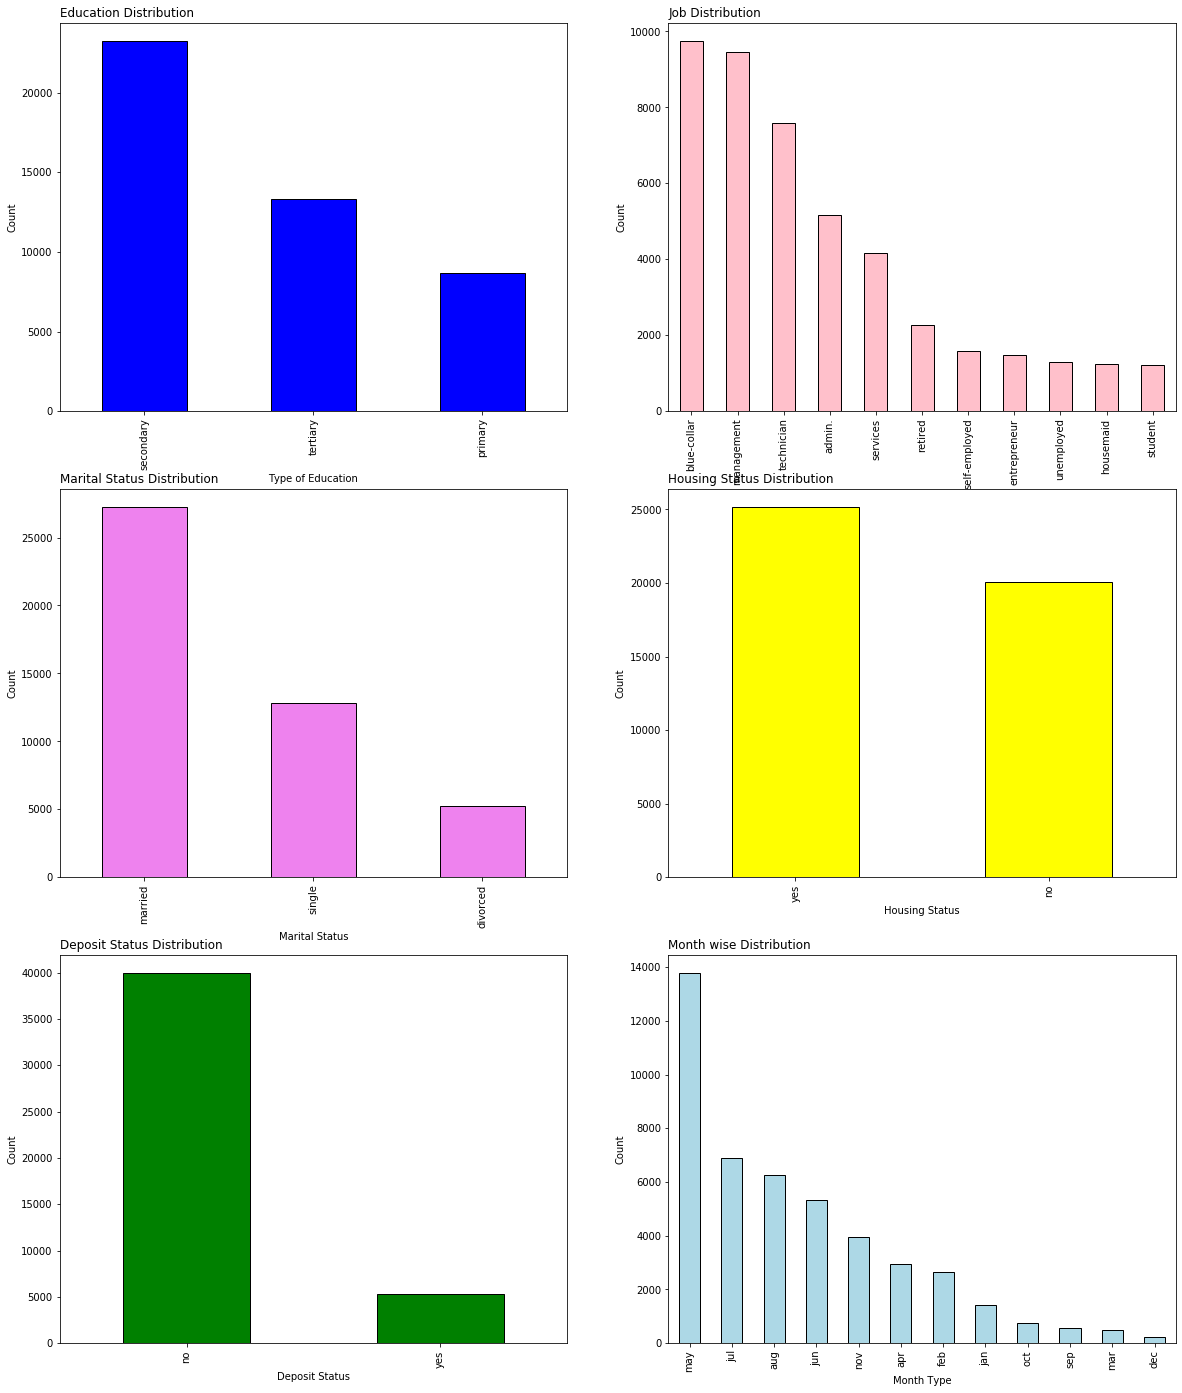

In [24]:
plt.figure(figsize=(20,50))


plt.subplot(6,2,1)
bank['education'].value_counts().plot(kind="bar", align='center',color = 'blue',edgecolor = 'black')
plt.xlabel("Type of Education")
plt.ylabel("Count")
plt.title("Education Distribution",loc='left')


plt.subplot(6,2,2)
bank['job'].value_counts().plot(kind="bar", align='center',color = 'pink',edgecolor = 'black')
plt.xlabel("Type of job")
plt.ylabel("Count")
plt.title("Job Distribution",loc='left')


plt.subplot(6,2,3)
bank['marital'].value_counts().plot(kind="bar", align='center',color = 'violet',edgecolor = 'black')
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.title("Marital Status Distribution",loc='left')

plt.subplot(6,2,4)
bank['housing'].value_counts().plot(kind="bar", align='center',color = 'yellow',edgecolor = 'black')
plt.xlabel("Housing Status")
plt.ylabel("Count")
plt.title("Housing Status Distribution",loc='left')

plt.subplot(6,2,5)
bank['deposit'].value_counts().plot(kind="bar", align='center',color = 'green',edgecolor = 'black')
plt.xlabel("Deposit Status")
plt.ylabel("Count")
plt.title("Deposit Status Distribution",loc='left')

plt.subplot(6,2,6)
bank['month'].value_counts().plot(kind="bar", align='center',color = 'lightblue',edgecolor = 'black')
plt.xlabel("Month Type")
plt.ylabel("Count")
plt.title("Month wise Distribution",loc='left')

plt.show()

**observation**
+ This is again a histogram distribution of categorical data points

# <font color = 'green'>Dependent Variable Analysis</font>

In [25]:
bank.deposit.value_counts().to_frame()

,deposit
no,39922
yes,5289


<function matplotlib.pyplot.show(*args, **kw)>

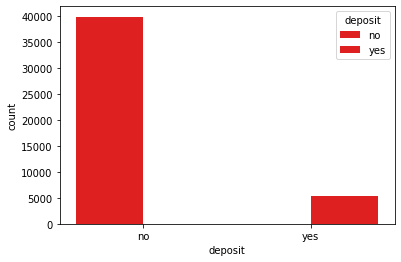

In [26]:
sns.countplot(x='deposit',data= bank,hue='deposit',palette=['Red'])
plt.show

**Observation**
+ Imbalanced class

# <font color = 'green'>Multivariate Analysis of Variables</font>

In [27]:
numerical_data

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

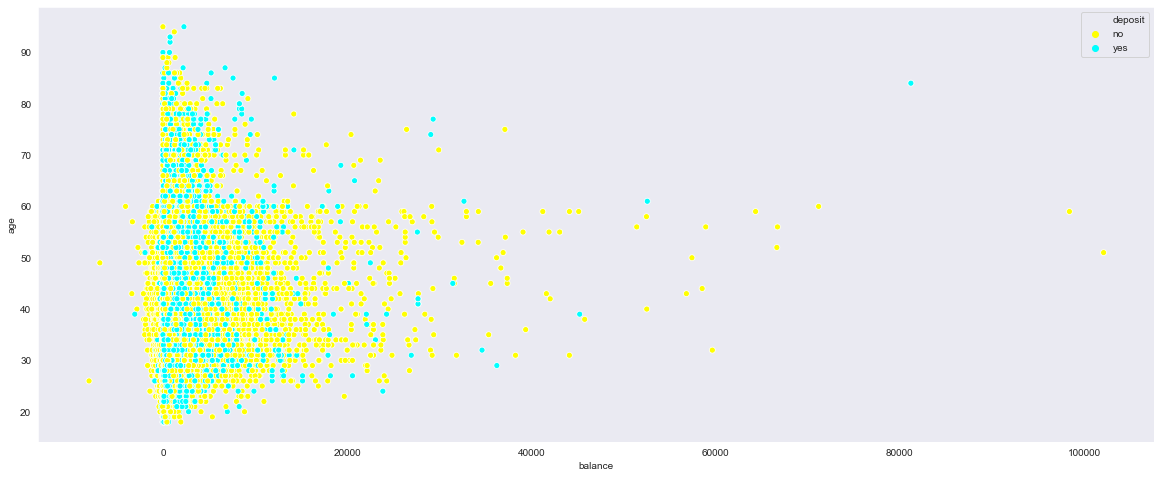

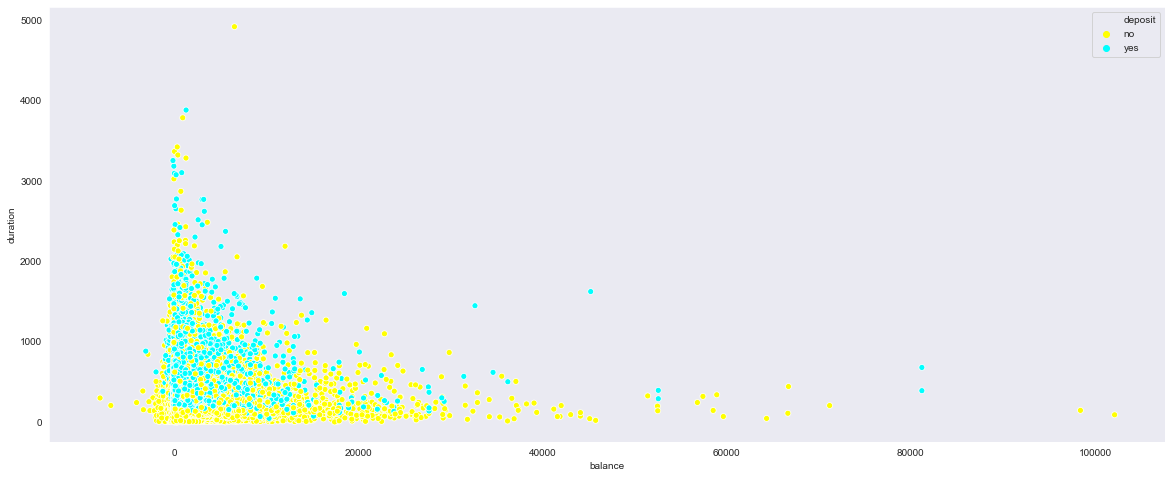

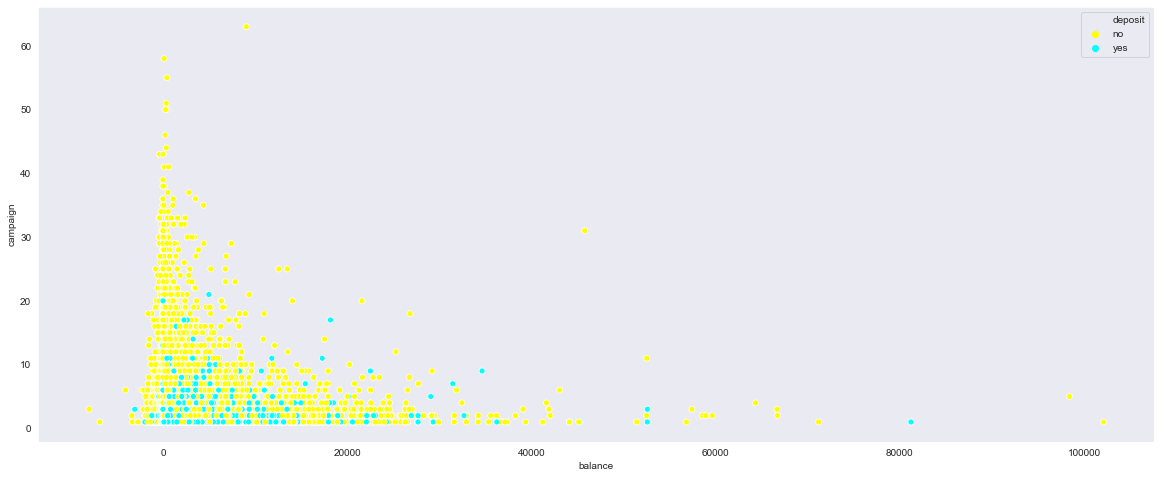

In [28]:
bank.deposit =bank.deposit.astype('str')
for i in ['age','duration','campaign']:
    plt.figure(figsize=(20,8))
    sns.set_style("dark")
    sns.scatterplot(x='balance',y=i,data=bank, hue='deposit',palette=["yellow","cyan"])
    plt.show
                                                                    
    

**observations**
+ Maximum number of people have low balance in their account.
+ Minimum the duration lesser the deposit rate.


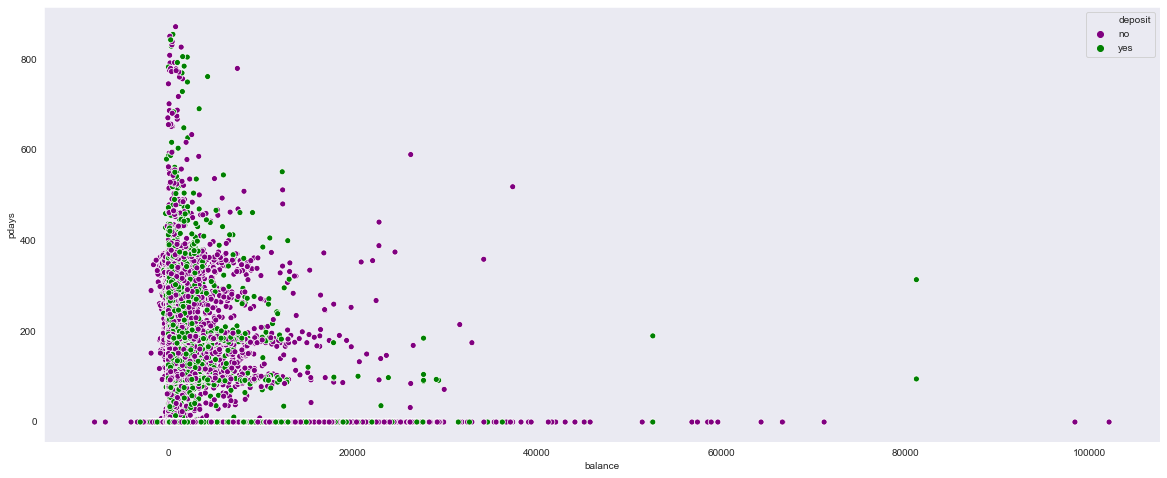

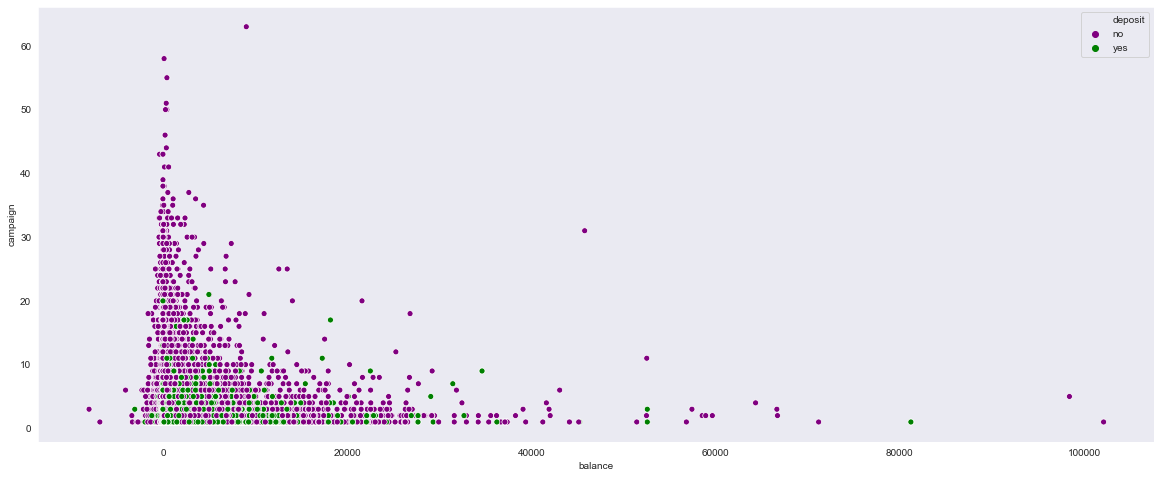

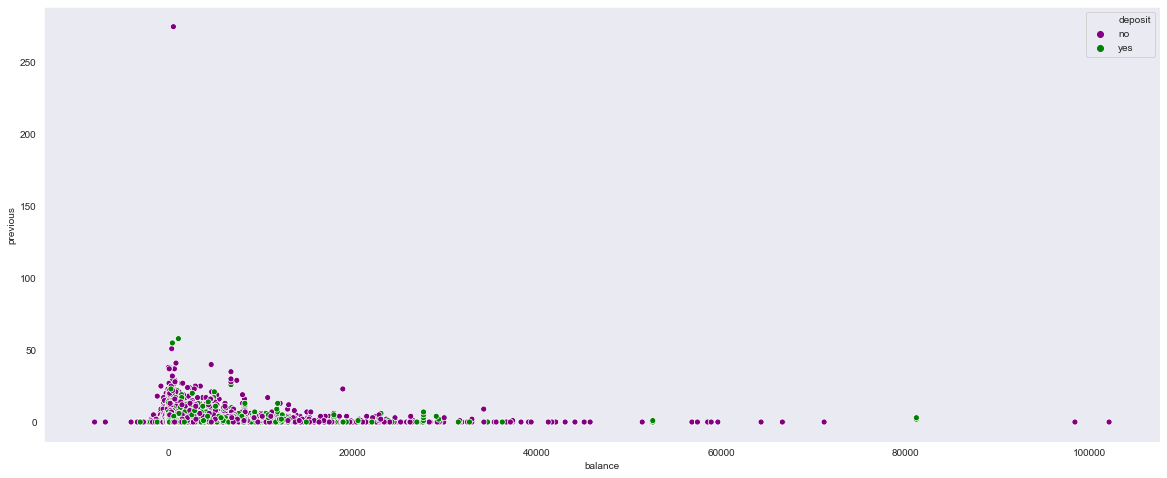

In [29]:
bank.deposit =bank.deposit.astype('str')
for i in ['pdays','campaign','previous']:
    plt.figure(figsize=(20,8))
    sns.set_style("dark")
    sns.scatterplot(x='balance',y=i,data=bank, hue='deposit',palette=["purple","green"])
    plt.show


**observation**
+ Deposit rate decrease with the increasing of passing day after the client was last contacted from a previous campaign.
+ Number of contacts performed before this campaign and for this client, deposit rate was very low before campaigning.

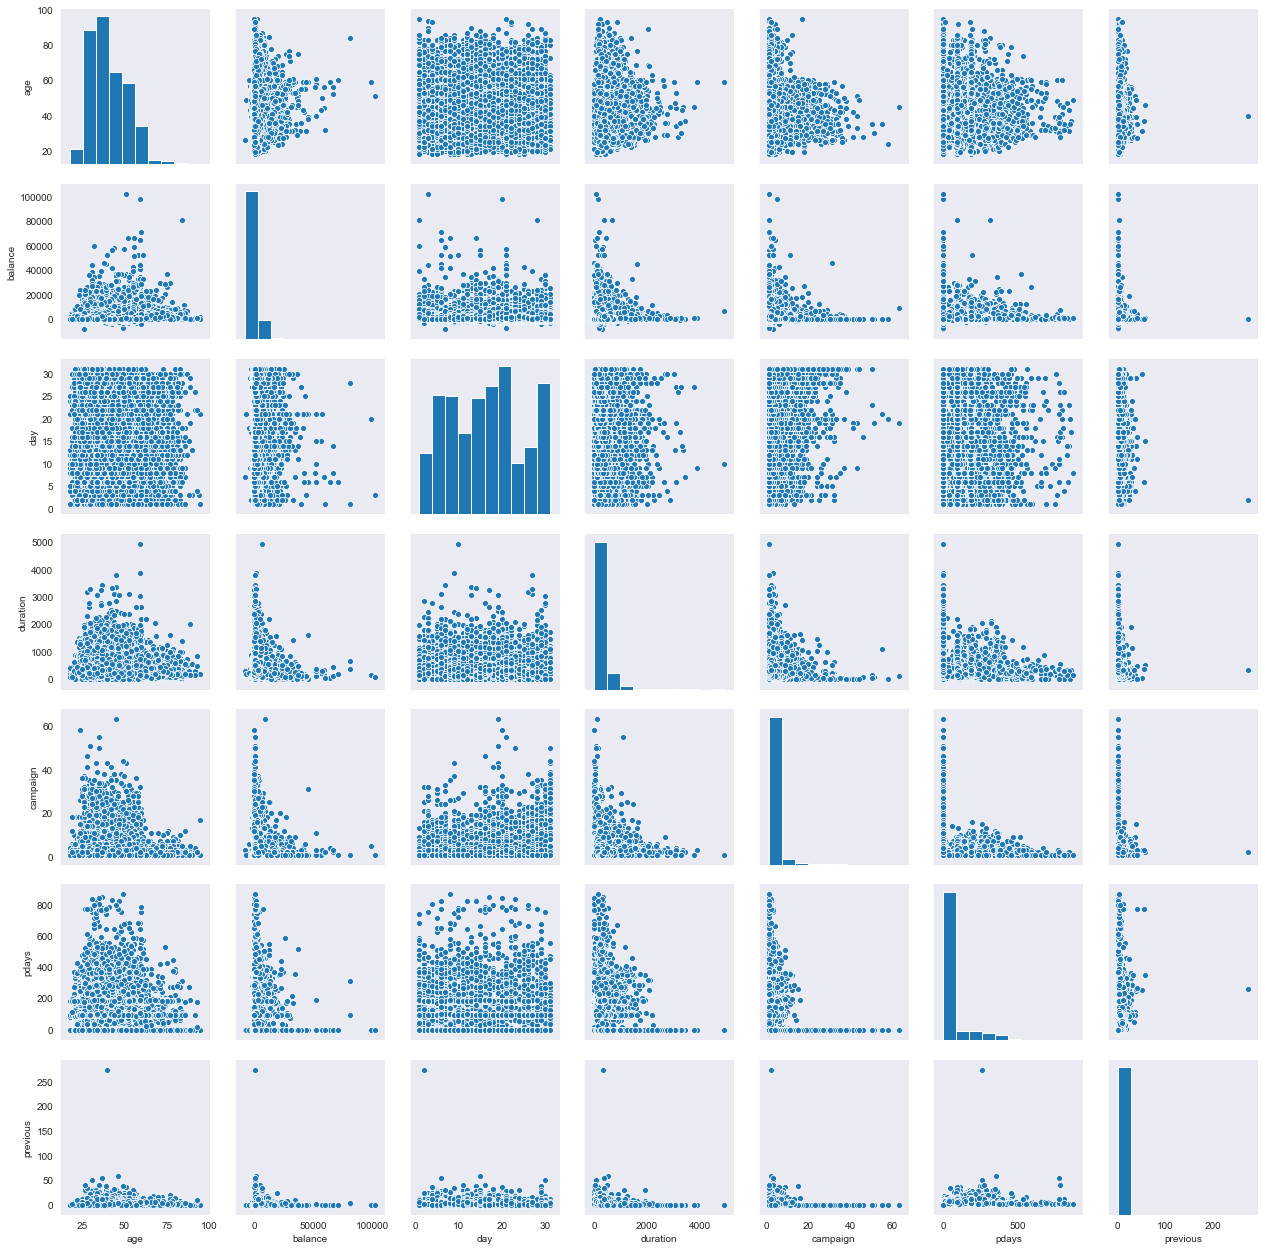

In [30]:
sns.pairplot(bank,palette='lightblue')
plt.show()

**observations**
+ Dont find any association among the independent variables

# <font color = 'crimson'>Numerical Independent Fields Description</font>

In [31]:
bank.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,"45,211.00",40.94,10.62,18.00,33.00,39.00,48.00,95.00
balance,"45,211.00","1,362.27","3,044.77","-8,019.00",72.00,448.00,"1,428.00","102,127.00"
day,"45,211.00",15.81,8.32,1.00,8.00,16.00,21.00,31.00
duration,"45,211.00",258.16,257.53,0.00,103.00,180.00,319.00,"4,918.00"
campaign,"45,211.00",2.76,3.10,1.00,1.00,2.00,3.00,63.00
pdays,"45,211.00",40.20,100.13,-1.00,-1.00,-1.00,-1.00,871.00
previous,"45,211.00",0.58,2.30,0.00,0.00,0.00,0.00,275.00


# <font color = 'crimson'>Correlation</font>

<function matplotlib.pyplot.show(*args, **kw)>

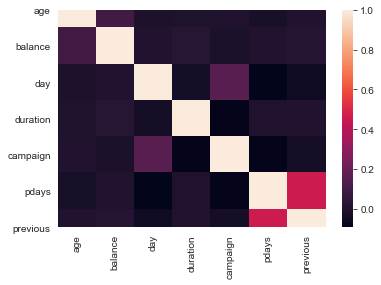

In [32]:
sns.heatmap(bank[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous']].corr())
plt.show

### <font color ='red'>Observation</font>
+ No high correlation between the independent variable

In [33]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,no
3,47,blue-collar,married,primary,no,1506,yes,no,unknown,5,may,92,1,-1,0,no
4,33,student,single,primary,no,1,no,no,unknown,5,may,198,1,-1,0,no


# <font color = 'crimson'>Mean Encoding</font>

In [34]:
# Mean Encoding

print('blue-collar,',9732/45211)
print('management,',9458/45211)
print('technician,',7597/45211)
print('admin.,',5171/45211)
print('Services,',4154/45211)
print('retired,',2264/45211)
print('self-employed,',1579/45211)
print('entrepreneur,',1487/45211)
print('unemployed,',1303/45211)
print('housemaid,',1240/45211)
print('student,',1226/45211)
print()

print('may,',13766/45211)
print('jul,',6895/45211)
print('aug,',6247/45211)
print('jun,',5341/45211)
print('nov,',3970/45211)
print('apr,',2932/45211)
print('feb,',2649/45211)
print('jan,',1403/45211)
print('oct,',738/45211)
print('sep,',579/45211)
print('mar,',477/45211)
print('dec,',214/45211)
print()
print('secondary:',23202/45211)
print('tertiary:',13301/45211)
print('primary:',8708/45211)
print()
print('married:',27214/45211)
print('single:',12790/45211)
print('divorced:',5207/45211)


blue-collar, 0.21525734887527373
management, 0.20919687686624935
technician, 0.16803432792904383
admin., 0.11437482028709828
Services, 0.09188029461856628
retired, 0.05007630886288735
self-employed, 0.03492512884032647
entrepreneur, 0.03289022582999712
unemployed, 0.028820419809338436
housemaid, 0.027426953617482472
student, 0.027117294463736702

may, 0.3044834221760191
jul, 0.15250713321979165
aug, 0.13817433810355886
jun, 0.11813496715401119
nov, 0.08781048859790759
apr, 0.06485147419875693
feb, 0.058591935590896024
jan, 0.031032270907522506
oct, 0.01632346110459844
sep, 0.012806617858485766
mar, 0.010550529738338015
dec, 0.00473336135011391

secondary: 0.513193691800668
tertiary: 0.29419831456946316
primary: 0.19260799362986883

married: 0.6019331578598128
single: 0.2828957554577426
divorced: 0.11517108668244454


In [35]:
bank['month']=bank['month'].replace('may',0.304)
bank['month']=bank['month'].replace('jul', 0.153)
bank['month']=bank['month'].replace('aug', 0.138)
bank['month']=bank['month'].replace('jun', 0.118)
bank['month']=bank['month'].replace('nov', 0.088)
bank['month']=bank['month'].replace('apr', 0.065)
bank['month']=bank['month'].replace('feb', 0.059)
bank['month']=bank['month'].replace('jan', 0.031)
bank['month']=bank['month'].replace('oct', 0.016)
bank['month']=bank['month'].replace('sep', 0.013)
bank['month']=bank['month'].replace('mar', 0.011)
bank['month']=bank['month'].replace('dec', 0.005)

print()

bank['job']=bank['job'].replace('blue-collar',0.215)
bank['job']=bank['job'].replace('management', 0.209)
bank['job']=bank['job'].replace('technician', 0.168)
bank['job']=bank['job'].replace('admin.', 0.114)
bank['job']=bank['job'].replace('services', 0.092)
bank['job']=bank['job'].replace('retired', 0.050)
bank['job']=bank['job'].replace('self-employed', 0.035)
bank['job']=bank['job'].replace('entrepreneur', 0.033)
bank['job']=bank['job'].replace('unemployed', 0.029)
bank['job']=bank['job'].replace('housemaid', 0.027)
bank['job']=bank['job'].replace('student', 0.027)
print()

bank['education']=bank['education'].replace('secondary',0.5131)
bank['education']=bank['education'].replace('tertiary',0.29419)
bank['education']=bank['education'].replace('primary',0.1926)
print()
bank['marital']=bank['marital'].replace('married',0.6019)
bank['marital']=bank['marital'].replace('single',0.2829)
bank['marital']=bank['marital'].replace('divorced',0.1151)
print()
bank['deposit']=bank['deposit'].replace('no',0)
bank['deposit']=bank['deposit'].replace('yes',1)

### <font color ='red'>Observation</font>
+ In the above `Mean Encoding` technique what we are doing we are dividing the sum of single category of a categorical variable by total number of observtions in the categorical variable. After getting the numerical value we are replacing the category name by its numeric mean.
+ We are applying this technique to reduce dummy variables.

In [36]:
bank.job.value_counts()

0.21    9732
0.21    9458
0.17    7597
0.11    5171
0.09    4154
0.03    2466
0.05    2264
0.04    1579
0.03    1487
0.03    1303
Name: job, dtype: int64

# <font color = 'crimson'>Data After Mean Encoding</font>

In [37]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,deposit
0,58,0.21,0.60,0.29,no,2143,yes,no,unknown,5,0.30,261,1,-1,0,0
1,44,0.17,0.28,0.51,no,29,yes,no,unknown,5,0.30,151,1,-1,0,0
2,33,0.03,0.60,0.51,no,2,yes,yes,unknown,5,0.30,76,1,-1,0,0
3,47,0.21,0.60,0.19,no,1506,yes,no,unknown,5,0.30,92,1,-1,0,0
4,33,0.03,0.28,0.19,no,1,no,no,unknown,5,0.30,198,1,-1,0,0


In [38]:
X = bank.drop(['default','deposit'],axis=1)
Y = bank['deposit'].values

In [39]:
X = pd.get_dummies(X, drop_first=True)

## <font color = 'crimson'>Data Splitting</font>

In [40]:
##Split into training and test set
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

In [41]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

In [42]:
X.head()

,age,job,marital,education,balance,day,month,duration,campaign,pdays,previous,housing_yes,loan_yes,contact_telephone,contact_unknown
0,58,0.21,0.60,0.29,2143,5,0.30,261,1,-1,0,1,0,0,1
1,44,0.17,0.28,0.51,29,5,0.30,151,1,-1,0,1,0,0,1
2,33,0.03,0.60,0.51,2,5,0.30,76,1,-1,0,1,1,0,1
3,47,0.21,0.60,0.19,1506,5,0.30,92,1,-1,0,1,0,0,1
4,33,0.03,0.28,0.19,1,5,0.30,198,1,-1,0,0,0,0,1


In [43]:
#Undersampled Data
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, Y)
print('Resampled dataset shape %s' % Counter(y_under))

#Oversampled Data
rus = RandomOverSampler(random_state=42)
X_over, y_over = rus.fit_resample(X, Y)
print('Resampled dataset shape %s' % Counter(y_over))

#SMOTE Data
rus = SMOTE(random_state=42)
X_smote, y_smote = rus.fit_resample(X, Y)
print('Resampled dataset shape %s' % Counter(y_smote))

Resampled dataset shape Counter({0: 5289, 1: 5289})
Resampled dataset shape Counter({0: 39922, 1: 39922})
Resampled dataset shape Counter({0: 39922, 1: 39922})


# <font color="coral">MODEL BUILDING</font>

#  <font color='crimson'>----------------------------------------- Logistic Regression ---------------------------------</font>

In [44]:
#Logistic Regression Model
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
logreg = LogisticRegression(solver='liblinear',C=0.5,random_state=42,max_iter=500,class_weight='balanced')

logreg.fit(X_train,y_train)
#predict
y_predict = logreg.predict(X_test)
training_accuracy = logreg.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = logreg.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)
print('roc_auc_score:',roc_auc_score(y_test,y_predict))
print("Recall:",recall_score(y_test,y_predict))
print("Precision:",precision_score(y_test,y_predict))
print(classification_report(y_test,y_predict))

training_accuracy: 0.8083546623692609
testing_accuracy: 0.8077263344146269
roc_auc_score: 0.8077950103516075
Recall: 0.8078848560700876
Precision: 0.3594097995545657
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     11966
           1       0.36      0.81      0.50      1598

    accuracy                           0.81     13564
   macro avg       0.66      0.81      0.69     13564
weighted avg       0.90      0.81      0.84     13564



In [45]:
#Logistic Regression Model
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
logreg = LogisticRegression(solver='newton-cg',C=1,random_state=42,max_iter=1000,class_weight='balanced')

logreg.fit(X_train,y_train)
#predict
y_predict = logreg.predict(X_test)
training_accuracy = logreg.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = logreg.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)
print('roc_auc_score:',roc_auc_score(y_test,y_predict))
print("Recall:",recall_score(y_test,y_predict))
print("Precision:",precision_score(y_test,y_predict))
print(classification_report(y_test,y_predict))

training_accuracy: 0.8081966695105381
testing_accuracy: 0.807800058979652
roc_auc_score: 0.8081079014654998
Recall: 0.8085106382978723
Precision: 0.3595880879487893
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     11966
           1       0.36      0.81      0.50      1598

    accuracy                           0.81     13564
   macro avg       0.66      0.81      0.69     13564
weighted avg       0.90      0.81      0.84     13564



## <font color = 'gold'>Logistic UnderSample</font>

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under, test_size = 0.30, random_state=42 )
#Logistic Regression Model
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
logreg = LogisticRegression(solver='newton-cg',C=0.5,random_state=42,max_iter=500)

logreg.fit(X_train,y_train)
#predict
y_predict = logreg.predict(X_test)
training_accuracy = logreg.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = logreg.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)
print('roc_auc_score:',roc_auc_score(y_test,y_predict))
print(classification_report(y_test,y_predict))

training_accuracy: 0.8923436660662938
testing_accuracy: 0.8875700383367738
roc_auc_score: 0.59305751987745
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     11966
           1       0.56      0.21      0.30      1598

    accuracy                           0.89     13564
   macro avg       0.73      0.59      0.62     13564
weighted avg       0.86      0.89      0.86     13564



## <font color = 'gold'> Logistic OverSample</font>

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_over,y_over, test_size = 0.30, random_state=42 )
#Logistic Regression Model
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
logreg = LogisticRegression(random_state=42, solver="lbfgs",penalty='l2',C=0.5,tol=0.001,max_iter=1000)

logreg.fit(X_train,y_train)
#predict
y_predict = logreg.predict(X_test)
training_accuracy = logreg.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = logreg.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)
print('roc_auc_score:',roc_auc_score(y_test,y_predict))
print(classification_report(y_test,y_predict))

training_accuracy: 0.8906689417638323
testing_accuracy: 0.8883072839870245
roc_auc_score: 0.5951020067914577
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     11966
           1       0.57      0.21      0.31      1598

    accuracy                           0.89     13564
   macro avg       0.74      0.60      0.62     13564
weighted avg       0.86      0.89      0.86     13564



## <font color = 'gold'>Logistic Smote</font>

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote, test_size = 0.30, random_state=42 )
#Logistic Regression Model
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
logreg = LogisticRegression(random_state=42, solver="lbfgs",penalty='l2',C=0.5,tol=0.001,max_iter=1000)

logreg.fit(X_train,y_train)
#predict
y_predict = logreg.predict(X_test)
training_accuracy = logreg.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = logreg.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)
print('roc_auc_score:',roc_auc_score(y_test,y_predict))
print(classification_report(y_test,y_predict))

training_accuracy: 0.8906689417638323
testing_accuracy: 0.8883072839870245
roc_auc_score: 0.5951020067914577
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     11966
           1       0.57      0.21      0.31      1598

    accuracy                           0.89     13564
   macro avg       0.74      0.60      0.62     13564
weighted avg       0.86      0.89      0.86     13564



## <font color ='red'>Observation</font>
+ **Average result when making basic model on imbalanced technique using a multiple parameter especially class weight equal to balanced.**
+ **Not a single good result from after applying balanced technique or hyper-parameter tuning.**
+ **Average score models**

# <font color='crimson'>----------------------------------------- DecisonTree ---------------------------------</font>

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
dt_model = DecisionTreeClassifier(criterion='entropy',random_state=42,class_weight='balanced')
dt_model.fit(X_train,y_train)
y_pred_dt = dt_model.predict(X_test)
print("Trainig accuracy",dt_model.score(X_train,y_train))  
print()
print("Testing accuracy",dt_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))

Trainig accuracy 1.0

Testing accuracy 0.8739309938071366

roc_auc_score: 0.6799432978336409
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     11966
           1       0.46      0.43      0.44      1598

    accuracy                           0.87     13564
   macro avg       0.69      0.68      0.69     13564
weighted avg       0.87      0.87      0.87     13564



In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
dt_model = DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=30,
                                 max_features='auto',min_samples_leaf=5,splitter='best',class_weight='balanced')
dt_model.fit(X_train,y_train)
y_pred_dt = dt_model.predict(X_test)
print("Trainig accuracy",dt_model.score(X_train,y_train))  
print()
print("Testing accuracy",dt_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))

Trainig accuracy 0.8726577558694347

Testing accuracy 0.8220289000294898

roc_auc_score: 0.7933995088712972
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     11966
           1       0.37      0.76      0.50      1598

    accuracy                           0.82     13564
   macro avg       0.67      0.79      0.70     13564
weighted avg       0.89      0.82      0.85     13564



In [51]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
dt_model = DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=30,
                                 max_features='auto',min_samples_leaf=5,splitter='best',class_weight='balanced')
dt_model.fit(X_train,y_train)
y_pred_dt = dt_model.predict(X_test)
print("Trainig accuracy",dt_model.score(X_train,y_train))  
print()
print("Testing accuracy",dt_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))

Trainig accuracy 0.8726577558694347

Testing accuracy 0.8220289000294898

roc_auc_score: 0.7933995088712972
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     11966
           1       0.37      0.76      0.50      1598

    accuracy                           0.82     13564
   macro avg       0.67      0.79      0.70     13564
weighted avg       0.89      0.82      0.85     13564



## <font color = 'gold'> Decision Tree UnderSample</font>

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under, test_size = 0.30, random_state=42 )
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
dt_model = DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=30,
                                 min_samples_leaf=7)
dt_model.fit(X_train,y_train)
y_pred_dt = dt_model.predict(X_test)
print("Trainig accuracy",dt_model.score(X_train,y_train))  
print()
print("Testing accuracy",dt_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))

Trainig accuracy 0.9432489651467754

Testing accuracy 0.8820406959598939

roc_auc_score: 0.678575320939575
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     11966
           1       0.50      0.41      0.45      1598

    accuracy                           0.88     13564
   macro avg       0.71      0.68      0.69     13564
weighted avg       0.87      0.88      0.88     13564



## <font color = 'gold'> Decision Tree OverSample</font>

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_over,y_over, test_size = 0.30, random_state=42 )
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
dt_model = DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=30,
                                 max_features='auto',min_samples_leaf=5,splitter='best')
dt_model.fit(X_train,y_train)
y_pred_dt = dt_model.predict(X_test)
print("Trainig accuracy",dt_model.score(X_train,y_train))  
print()
print("Testing accuracy",dt_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))

Trainig accuracy 0.9307675293076753

Testing accuracy 0.8840312592155706

roc_auc_score: 0.6696725934160137
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     11966
           1       0.51      0.39      0.44      1598

    accuracy                           0.88     13564
   macro avg       0.72      0.67      0.69     13564
weighted avg       0.87      0.88      0.88     13564



## <font color = 'gold'>Decision Tree SMOTE</font>

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote, test_size = 0.30, random_state=42 )
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
dt_model = DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=30,
                                 max_features='auto',min_samples_leaf=5,splitter='best')
dt_model.fit(X_train,y_train)
y_pred_dt = dt_model.predict(X_test)
print("Trainig accuracy",dt_model.score(X_train,y_train))  
print()
print("Testing accuracy",dt_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))

Trainig accuracy 0.9307675293076753

Testing accuracy 0.8840312592155706

roc_auc_score: 0.6696725934160137
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     11966
           1       0.51      0.39      0.44      1598

    accuracy                           0.88     13564
   macro avg       0.72      0.67      0.69     13564
weighted avg       0.87      0.88      0.88     13564



## <font color ='red'>Observation</font>
+ **Average result when making basic model on imbalanced technique using a multiple parameter especially class weight equal to balanced.**
+ **Not a single good result from after applying balanced technique or hyper-parameter tuning.**
+ **Average score models**

# <font color='crimson'>----------------------------------------- AdBoosting ---------------------------------</font>

In [55]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
AdaBoost_model = AdaBoostClassifier()
AdaBoost_model.fit(X_train,y_train)

y_pred_Ada = AdaBoost_model.predict(X_test)

print("Trainig accuracy",AdaBoost_model.score(X_train,y_train))  
print()
print("Testing accuracy",AdaBoost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_Ada))
print(classification_report(y_test,y_pred_Ada))


Trainig accuracy 0.894966347521092

Testing accuracy 0.8919935122382778

roc_auc_score: 0.6468036679645311
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     11966
           1       0.57      0.33      0.42      1598

    accuracy                           0.89     13564
   macro avg       0.74      0.65      0.68     13564
weighted avg       0.87      0.89      0.88     13564



## <font color = 'gold'> Ad Boosting UnderSample</font>

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under, test_size = 0.30, random_state=42 )
AdaBoost_model = AdaBoostClassifier()
AdaBoost_model.fit(X_train,y_train)

y_pred_Ada = AdaBoost_model.predict(X_test)

print("Trainig accuracy",AdaBoost_model.score(X_train,y_train))  
print()
print("Testing accuracy",AdaBoost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_Ada))
print(classification_report(y_test,y_pred_Ada))


Trainig accuracy 0.832117774176121

Testing accuracy 0.8172652804032766

roc_auc_score: 0.8172817213799765
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1618
           1       0.81      0.82      0.81      1556

    accuracy                           0.82      3174
   macro avg       0.82      0.82      0.82      3174
weighted avg       0.82      0.82      0.82      3174



## <font color = 'gold'>Ad Boosting OverSample</font>

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_over,y_over, test_size = 0.30, random_state=42 )
AdaBoost_model = AdaBoostClassifier()
AdaBoost_model.fit(X_train,y_train)

y_pred_Ada = AdaBoost_model.predict(X_test)

print("Trainig accuracy",AdaBoost_model.score(X_train,y_train))  
print()
print("Testing accuracy",AdaBoost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_Ada))
print(classification_report(y_test,y_pred_Ada))


Trainig accuracy 0.8332080873143675

Testing accuracy 0.8305919679385488

roc_auc_score: 0.8305927576955783
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     11973
           1       0.83      0.83      0.83     11981

    accuracy                           0.83     23954
   macro avg       0.83      0.83      0.83     23954
weighted avg       0.83      0.83      0.83     23954



## <font color = 'gold'>Ad Boosting SMOTE</font>

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote, test_size = 0.30, random_state=42 )
AdaBoost_model = AdaBoostClassifier()
AdaBoost_model.fit(X_train,y_train)

y_pred_Ada = AdaBoost_model.predict(X_test)

print("Trainig accuracy",AdaBoost_model.score(X_train,y_train))  
print()
print("Testing accuracy",AdaBoost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_Ada))
print(classification_report(y_test,y_pred_Ada))


Trainig accuracy 0.9140275541241725

Testing accuracy 0.913751356767137

roc_auc_score: 0.9137535221435164
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     11973
           1       0.92      0.91      0.91     11981

    accuracy                           0.91     23954
   macro avg       0.91      0.91      0.91     23954
weighted avg       0.91      0.91      0.91     23954



## <font color ='red'>Observation</font>
+ **Poor result before balancing.**
+ **Good result after balancing the data in all the three categories.**
+ **Best scores in `SMOTE` technique, no hyper-parameter tuning has been done.**


# <font color='crimson'>----------------------------------------- GradientBoosting ---------------------------------</font>

In [59]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
g_boost_model = GradientBoostingClassifier(random_state=42)
g_boost_model.fit(X_train,y_train)
y_pred_g_boost = g_boost_model.predict(X_test)

print("Trainig accuracy",g_boost_model.score(X_train,y_train))  
print()
print("Testing accuracy",g_boost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_g_boost))
print(classification_report(y_test,y_pred_g_boost))


Trainig accuracy 0.9066578190665782

Testing accuracy 0.9020200530816869

roc_auc_score: 0.6809525717107943
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     11966
           1       0.64      0.39      0.49      1598

    accuracy                           0.90     13564
   macro avg       0.78      0.68      0.72     13564
weighted avg       0.89      0.90      0.89     13564



In [60]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
g_boost_model = GradientBoostingClassifier(learning_rate=0.07,n_estimators=70,subsample=0.2,max_depth=12,random_state=42)
g_boost_model.fit(X_train,y_train)
y_pred_g_boost = g_boost_model.predict(X_test)

print("Trainig accuracy",g_boost_model.score(X_train,y_train))  
print()
print("Testing accuracy",g_boost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_g_boost))
print(classification_report(y_test,y_pred_g_boost))


Trainig accuracy 0.9561727809902992

Testing accuracy 0.8981126511353583

roc_auc_score: 0.6990709178718092
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     11966
           1       0.59      0.44      0.50      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.70      0.72     13564
weighted avg       0.89      0.90      0.89     13564



## <font color = 'gold'>Gradient Boosting UnderSample</font>

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under, test_size = 0.30, random_state=42 )
g_boost_model = GradientBoostingClassifier(learning_rate=0.07,n_estimators=70,subsample=0.2,max_depth=12,random_state=42)
g_boost_model.fit(X_train,y_train)
y_pred_g_boost = g_boost_model.predict(X_test)

print("Trainig accuracy",g_boost_model.score(X_train,y_train))  
print()
print("Testing accuracy",g_boost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_g_boost))
print(classification_report(y_test,y_pred_g_boost))

Trainig accuracy 0.94462452728255

Testing accuracy 0.8440453686200378

roc_auc_score: 0.8448169850111693
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1618
           1       0.81      0.88      0.85      1556

    accuracy                           0.84      3174
   macro avg       0.85      0.84      0.84      3174
weighted avg       0.85      0.84      0.84      3174



## <font color = 'gold'>Gradient Boosting OverSample</font>

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_over,y_over, test_size = 0.30, random_state=42 )
g_boost_model = GradientBoostingClassifier(learning_rate=0.07,n_estimators=70,subsample=0.2,max_depth=12,random_state=42)
g_boost_model.fit(X_train,y_train)
y_pred_g_boost = g_boost_model.predict(X_test)

print("Trainig accuracy",g_boost_model.score(X_train,y_train))  
print()
print("Testing accuracy",g_boost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_g_boost))
print(classification_report(y_test,y_pred_g_boost))

Trainig accuracy 0.9619073179459653

Testing accuracy 0.9329548300910078

roc_auc_score: 0.932938259178748
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     11973
           1       0.89      0.98      0.94     11981

    accuracy                           0.93     23954
   macro avg       0.94      0.93      0.93     23954
weighted avg       0.94      0.93      0.93     23954



## <font color = 'gold'>Gradient Boosting SMOTE</font>

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote, test_size = 0.30, random_state=42 )
g_boost_model = GradientBoostingClassifier(learning_rate=0.07,n_estimators=70,subsample=0.2,max_depth=12,random_state=42)
g_boost_model.fit(X_train,y_train)
y_pred_g_boost = g_boost_model.predict(X_test)

print("Trainig accuracy",g_boost_model.score(X_train,y_train))  
print()
print("Testing accuracy",g_boost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_g_boost))
print(classification_report(y_test,y_pred_g_boost))

Trainig accuracy 0.9739488280551083

Testing accuracy 0.9413459129999165

roc_auc_score: 0.9413444425178531
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     11973
           1       0.94      0.95      0.94     11981

    accuracy                           0.94     23954
   macro avg       0.94      0.94      0.94     23954
weighted avg       0.94      0.94      0.94     23954



## <font color ='red'>Observation</font>
+ **Average result before balancing.**
+ **Good result after balancing the data in all the three categories.**
+ **Best scores in `OverSampling` technique, hyper-parameter tuning has been done on few parameters.**


# <font color='crimson'>----------------------------------------- XGBoost ---------------------------------</font>

In [64]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
xg_boost_model = XGBClassifier(class_weight='balanced')
xg_boost_model.fit(X_train,y_train)
y_pred_xg_boost = g_boost_model.predict(X_test)
print("Trainig accuracy",xg_boost_model.score(X_train,y_train))  
print()
print("Testing accuracy",xg_boost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_xg_boost))
print()
print(classification_report(y_test,y_pred_xg_boost))

Trainig accuracy 0.9570891395708914

Testing accuracy 0.9060749041580655

roc_auc_score: 0.8483821599663796

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     11966
           1       0.71      0.74      0.72      1598

    accuracy                           0.93     13564
   macro avg       0.84      0.85      0.84     13564
weighted avg       0.93      0.93      0.93     13564



## <font color = 'gold'>XG Boosting UnderSample</font>

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under, test_size = 0.30, random_state=42 )
xg_boost_model = XGBClassifier(class_weight='balanced')
xg_boost_model.fit(X_train,y_train)
y_pred_xg_boost = g_boost_model.predict(X_test)
print("Trainig accuracy",xg_boost_model.score(X_train,y_train))  
print()
print("Testing accuracy",xg_boost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_xg_boost))
print()
print(classification_report(y_test,y_pred_xg_boost))

Trainig accuracy 0.9729875742841707

Testing accuracy 0.8490863264020164

roc_auc_score: 0.8537758856819648

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1618
           1       0.94      0.76      0.84      1556

    accuracy                           0.86      3174
   macro avg       0.87      0.85      0.85      3174
weighted avg       0.87      0.86      0.85      3174



## <font color = 'gold'>XG Boosting OverSample</font>

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_over,y_over, test_size = 0.30, random_state=42 )
xg_boost_model = XGBClassifier()
xg_boost_model.fit(X_train,y_train)
y_pred_xg_boost = g_boost_model.predict(X_test)
print("Trainig accuracy",xg_boost_model.score(X_train,y_train))  
print()
print("Testing accuracy",xg_boost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_xg_boost))
print()
print(classification_report(y_test,y_pred_xg_boost))

Trainig accuracy 0.9391483270710324

Testing accuracy 0.9170493445771061

roc_auc_score: 0.840142539504749

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     11973
           1       0.92      0.74      0.82     11981

    accuracy                           0.84     23954
   macro avg       0.85      0.84      0.84     23954
weighted avg       0.85      0.84      0.84     23954



## <font color = 'gold'>XG Boosting SMOTE</font>

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote, test_size = 0.30, random_state=42 )
xg_boost_model = XGBClassifier()
xg_boost_model.fit(X_train,y_train)
y_pred_xg_boost = g_boost_model.predict(X_test)
print("Trainig accuracy",xg_boost_model.score(X_train,y_train))  
print()
print("Testing accuracy",xg_boost_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_xg_boost))
print()
print(classification_report(y_test,y_pred_xg_boost))

Trainig accuracy 0.9723564143853999

Testing accuracy 0.9427235534774986

roc_auc_score: 0.9413444425178531

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     11973
           1       0.94      0.95      0.94     11981

    accuracy                           0.94     23954
   macro avg       0.94      0.94      0.94     23954
weighted avg       0.94      0.94      0.94     23954



## <font color ='red'>Observation</font>
+ **Average result before balancing.**
+ **Average result after balancing the data in `under` & `over` sampling techniques.**
+ **Best scores in `SMOTE` technique, no hyper-parameter tuning has been done.**


# <font color='crimson'>----------------------------------------- Bagging ---------------------------------</font>

In [68]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
Bag_model = BaggingClassifier()
Bag_model.fit(X_train,y_train)
y_pred_bag = Bag_model.predict(X_test)
print("Trainig accuracy",Bag_model.score(X_train,y_train))  
print()
print("Testing accuracy",Bag_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_bag))
print(classification_report(y_test,y_pred_bag))


Trainig accuracy 0.9921951527790944

Testing accuracy 0.8977440283102329

roc_auc_score: 0.6815112049848372
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11966
           1       0.60      0.40      0.48      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.68      0.71     13564
weighted avg       0.88      0.90      0.89     13564



## <font color = 'gold'>Bagging UnderSample</font>

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under, test_size = 0.30, random_state=42 )
Bag_model = BaggingClassifier()
Bag_model.fit(X_train,y_train)
y_pred_bag = Bag_model.predict(X_test)
print("Trainig accuracy",Bag_model.score(X_train,y_train))  
print()
print("Testing accuracy",Bag_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_bag))
print(classification_report(y_test,y_pred_bag))


Trainig accuracy 0.990815775256618

Testing accuracy 0.8333333333333334

roc_auc_score: 0.833522136885488
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1618
           1       0.82      0.84      0.83      1556

    accuracy                           0.83      3174
   macro avg       0.83      0.83      0.83      3174
weighted avg       0.83      0.83      0.83      3174



## <font color = 'gold'>Bagging OverSample</font>

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_over,y_over, test_size = 0.30, random_state=42 )
Bag_model = BaggingClassifier()
Bag_model.fit(X_train,y_train)
y_pred_bag = Bag_model.predict(X_test)
print("Trainig accuracy",Bag_model.score(X_train,y_train))  
print()
print("Testing accuracy",Bag_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_bag))
print(classification_report(y_test,y_pred_bag))


Trainig accuracy 0.9986938629450707

Testing accuracy 0.9607998664106203

roc_auc_score: 0.9607875788855336
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     11973
           1       0.93      1.00      0.96     11981

    accuracy                           0.96     23954
   macro avg       0.96      0.96      0.96     23954
weighted avg       0.96      0.96      0.96     23954



## <font color = 'gold'>Bagging SMOTE</font>

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote, test_size = 0.30, random_state=42 )
Bag_model = BaggingClassifier()
Bag_model.fit(X_train,y_train)
y_pred_bag = Bag_model.predict(X_test)
print("Trainig accuracy",Bag_model.score(X_train,y_train))  
print()
print("Testing accuracy",Bag_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_bag))
print(classification_report(y_test,y_pred_bag))


Trainig accuracy 0.996027911969941

Testing accuracy 0.9340402438006179

roc_auc_score: 0.9340423556708461
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     11973
           1       0.94      0.93      0.93     11981

    accuracy                           0.93     23954
   macro avg       0.93      0.93      0.93     23954
weighted avg       0.93      0.93      0.93     23954



## <font color ='red'>Observation</font>
+ **Poor result before balancing the dependent variable classes.**
+ **Good result after balancing the classes in `Under` sampling technique.**
+ **Better result after balancing the classes in `SMOTE` sampling technique.**
+ **Best scores in `Over` Sampling Technique.**
+ **No hyper-parameter tuning has been done in any of the imbalancing technique.**
+ **So far `Bagging` giving us the `Best` results among all the algorithms we have used above.**


# <font color='crimson'>----------------------------------------- Random Forest ---------------------------------</font>

In [72]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train,y_train)
y_pred_rf = dt_model.predict(X_test)
print("Trainig accuracy",rf_model.score(X_train,y_train))  
print()
print("Testing accuracy",rf_model.score(X_test, y_test))
print()
#print('roc_auc_score:',roc_auc_score(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

Trainig accuracy 0.9999684014282555

Testing accuracy 0.9014302565614863

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     11966
           1       0.51      0.39      0.44      1598

    accuracy                           0.88     13564
   macro avg       0.72      0.67      0.69     13564
weighted avg       0.87      0.88      0.88     13564



## <font color = 'gold'>Random Forest UnderSample</font>

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under, test_size = 0.30, random_state=42 )
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train,y_train)
y_pred_rf = dt_model.predict(X_test)
print("Trainig accuracy",rf_model.score(X_train,y_train))  
print()
print("Testing accuracy",rf_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

Trainig accuracy 1.0

Testing accuracy 0.8418399495904222

roc_auc_score: 0.7433603642822869
              precision    recall  f1-score   support

           0       0.68      0.96      0.80      1618
           1       0.93      0.52      0.67      1556

    accuracy                           0.75      3174
   macro avg       0.80      0.74      0.73      3174
weighted avg       0.80      0.75      0.73      3174



## <font color = 'gold'>Random Forest OverSample</font>

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_over,y_over, test_size = 0.30, random_state=42 )
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
y_pred_rf = dt_model.predict(X_test)
print("Trainig accuracy",rf_model.score(X_train,y_train))  
print()
print("Testing accuracy",rf_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

Trainig accuracy 1.0

Testing accuracy 0.9630959338732571

roc_auc_score: 0.7426643871867811
              precision    recall  f1-score   support

           0       0.67      0.97      0.79     11973
           1       0.94      0.52      0.67     11981

    accuracy                           0.74     23954
   macro avg       0.80      0.74      0.73     23954
weighted avg       0.80      0.74      0.73     23954



## <font color = 'gold'>Random Forest SMOTE</font>

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote, test_size = 0.30, random_state=42 )
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
y_pred_rf = dt_model.predict(X_test)
print("Trainig accuracy",rf_model.score(X_train,y_train))  
print()
print("Testing accuracy",rf_model.score(X_test, y_test))
print()
print('roc_auc_score:',roc_auc_score(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

Trainig accuracy 0.9999821077115764

Testing accuracy 0.943975953911664

roc_auc_score: 0.7129089410637529
              precision    recall  f1-score   support

           0       0.64      0.97      0.77     11973
           1       0.93      0.46      0.62     11981

    accuracy                           0.71     23954
   macro avg       0.79      0.71      0.69     23954
weighted avg       0.79      0.71      0.69     23954



## <font color ='red'>Observation</font>
+ **Average reult on imbalanced depndent variable classes.**
+ **Great result after applying three different imbalanced techniques.**
+ **No hyper-parameters has been tunned.**


# <font color ='green'>Conclusion:</font>

+ **This case was an imbalanced classifiction problem, our goal is to not achieve good accuracy. We were required a good recall score as well as other classification scores for `class 1` of our dependent variable `deposit`.**
+ **So far in all the algorithms `Bagging` giving us best `Recall` as well as other classification scores without any hype-parameter tuning, using `Over Sampling Technique` for balancing imbalanced problem.**

# <font color='crimson'>Model Compilation into DataFrame</font>

In [76]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
algo = []
tr = []
te=[]
recall=[]
precision=[]
roc=[]

In [77]:
#Base Models

#Logistic Regrssion
model = LogisticRegression(random_state=42,class_weight='balanced')
model.fit(X_train,y_train)
algo.append('Logistic Regression')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Decision Tree
model = DecisionTreeClassifier(class_weight='balanced',random_state=42)
model.fit(X_train,y_train)
algo.append('Decision Tree')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Ada Boosting
model =AdaBoostClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('Ad Boosting')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Gradient Boosting
model =GradientBoostingClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('Gradient Boosting')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#XG Boost
model =XGBClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('XG Boost')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))


#Bagging
model =BaggingClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('Bagging')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#RandomForest
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
model = RandomForestClassifier(class_weight='balanced',random_state=42)
model.fit(X_train,y_train)
algo.append('Random Forest')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))


results=pd.DataFrame()
results['Model']=algo
results['Training Score'] =tr
results['Test Score'] =te
results['Recall'] =recall
results['Precision'] =precision
results['ROC AUC Score'] =roc
results=results.set_index('Model')

In [78]:
#Oversampled Data
rus = RandomOverSampler(random_state=42)
X, Y = rus.fit_resample(X, Y)

#Logistic Regrssion
model = LogisticRegression(random_state=42, solver="lbfgs",penalty='l2',C=0.5,tol=0.001,max_iter=10000)
model.fit(X_train,y_train)
algo.append('Logistic Regression')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Decision Tree
model = DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=30,
                                 max_features='auto',min_samples_leaf=5,splitter='best')
model.fit(X_train,y_train)
algo.append('Decision Tree')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Ada Boosting
model =AdaBoostClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('Ad Boosting')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Gradient Boosting
model =GradientBoostingClassifier(learning_rate=0.07,n_estimators=70,subsample=0.2,max_depth=12,random_state=42)
model.fit(X_train,y_train)
algo.append('Gradient Boosting')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#XG Boost
model =XGBClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('XG Boost')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))


#Bagging
model =BaggingClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('Bagging')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#RandomForest
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train,y_train)
algo.append('Random Forest')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))


results=pd.DataFrame()
results['Model']=algo
results['Training Score'] =tr
results['Test Score'] =te
results['Recall'] =recall
results['Precision'] =precision
results['ROC AUC Score'] =roc
results=results.set_index('Model')

In [79]:
#Undersampled Data
rus = RandomUnderSampler(random_state=42)
X, Y = rus.fit_resample(X, Y)

#Logistic Regrssion
model = LogisticRegression(random_state=42, solver="lbfgs",penalty='l2',C=0.5,tol=0.001,max_iter=10000)
model.fit(X_train,y_train)
algo.append('Logistic Regression')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Decision Tree
model = DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=30,
                                 max_features='auto',min_samples_leaf=5,splitter='best')
model.fit(X_train,y_train)
algo.append('Decision Tree')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Ada Boosting
model =AdaBoostClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('Ad Boosting')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Gradient Boosting
model =GradientBoostingClassifier(learning_rate=0.07,n_estimators=70,subsample=0.2,max_depth=12,random_state=42)
model.fit(X_train,y_train)
algo.append('Gradient Boosting')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#XG Boost
model =XGBClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('XG Boost')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))


#Bagging
model =BaggingClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('Bagging')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#RandomForest
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train,y_train)
algo.append('Random Forest')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))
results=pd.DataFrame()
results['Model']=algo
results['Training Score'] =tr
results['Test Score'] =te
results['Recall'] =recall
results['Precision'] =precision
results['ROC AUC Score'] =roc
results=results.set_index('Model')

In [80]:
#SMOTE Data
rus = SMOTE(random_state=42)
X_smote, y_smote = rus.fit_resample(X, Y)

#Logistic Regrssion
model = LogisticRegression(random_state=42, solver="lbfgs",penalty='l2',C=0.5,tol=0.001,max_iter=10000)
model.fit(X_train,y_train)
algo.append('Logistic Regression')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Decision Tree
model = DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=30,
                                 max_features='auto',min_samples_leaf=5,splitter='best')
model.fit(X_train,y_train)
algo.append('Decision Tree')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Ada Boosting
model =AdaBoostClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('Ad Boosting')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#Gradient Boosting
model =GradientBoostingClassifier(learning_rate=0.07,n_estimators=70,subsample=0.2,max_depth=12,random_state=42)
model.fit(X_train,y_train)
algo.append('Gradient Boosting')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#XG Boost
model =XGBClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('XG Boost')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))


#Bagging
model =BaggingClassifier(random_state=42)
model.fit(X_train,y_train)
algo.append('Bagging')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))

#RandomForest
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train,y_train)
algo.append('Random Forest')
tr.append(model.score(X_train,y_train))
te.append(model.score(X_test,y_test))
recall.append(recall_score(y_test,model.predict(X_test)))
precision.append(precision_score(y_test,model.predict(X_test)))
roc.append(recall_score(y_test,model.predict(X_test)))


results=pd.DataFrame()
results['Model']=algo
results['Training Score'] =tr
results['Test Score'] =te
results['Recall'] =recall
results['Precision'] =precision
results['ROC AUC Score'] =roc
results=results.set_index('Model')

In [81]:
Technique =['Imbalanced','Imbalanced','Imbalanced','Imbalanced','Imbalanced','Imbalanced','Imbalanced',
           'Over Sampling','Over Sampling','Over Sampling','Over Sampling','Over Sampling','Over Sampling','Over Sampling',
           'Under Sampling','Under Sampling','Under Sampling','Under Sampling','Under Sampling','Under Sampling','Under Sampling',
           'SMOTE','SMOTE','SMOTE','SMOTE','SMOTE','SMOTE','SMOTE']
results['Technique']=Technique

In [84]:
results = results.reset_index()
results.set_index('Technique')

,Model,Training Score,Test Score,Recall,Precision,ROC AUC Score
Technique,,,,,,
Imbalanced,Logistic Regression,0.80,0.80,0.79,0.35,0.79
Imbalanced,Decision Tree,1.00,0.88,0.42,0.47,0.42
Imbalanced,Ad Boosting,0.89,0.89,0.33,0.57,0.33
Imbalanced,Gradient Boosting,0.91,0.90,0.39,0.64,0.39
Imbalanced,XG Boost,0.96,0.91,0.49,0.63,0.49
Imbalanced,Bagging,0.99,0.90,0.39,0.60,0.39
Imbalanced,Random Forest,1.00,0.90,0.34,0.68,0.34
Over Sampling,Logistic Regression,0.89,0.89,0.21,0.57,0.21
Over Sampling,Decision Tree,0.93,0.88,0.39,0.51,0.39


In [82]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')